In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import anndata as ad

In [2]:
Cell_tagMulti = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_test_multi_Seurat_clone_id.h5ad"
Cell_tag = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_train_tag_Seurat.h5ad"

Cell_tagMulti = ad.read_h5ad(Cell_tagMulti)
Cell_tag = ad.read_h5ad(Cell_tag)

### load proj head embedding

In [3]:
embed_path = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Cell_tag-Cell_tag_multi"

train_001_5 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab5_bs250_testAsPenalty/train_proj_embed.npy")
train_001_15 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab15_bs250_testAsPenalty/train_proj_embed.npy")
train_001_25 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_001_50 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab50_bs250_testAsPenalty/train_proj_embed.npy")
train_005_50 = np.load(embed_path + "/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/train_proj_embed.npy")


train_01_25 = np.load(embed_path + "/feat_celltagMulti_lambda0.1_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_1_25 = np.load(embed_path + "/feat_celltagMulti_lambda1_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_2_25 = np.load(embed_path + "/feat_celltagMulti_lambda2_unlab25_bs250_testAsPenalty/train_proj_embed.npy")
train_10_25 = np.load(embed_path + "/feat_celltagMulti_lambda10_unlab25_bs250_testAsPenalty/train_proj_embed.npy")


test_001_5 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab5_bs250_testAsPenalty/test_proj_embed.npy")
test_001_15 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab15_bs250_testAsPenalty/test_proj_embed.npy")
test_001_25 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_001_50 = np.load(embed_path + "/feat_celltagMulti_lambda001_unlab50_bs250_testAsPenalty/test_proj_embed.npy")
test_005_50 = np.load(embed_path + "/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/test_proj_embed.npy")

test_01_25 = np.load(embed_path + "/feat_celltagMulti_lambda0.1_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_1_25 = np.load(embed_path + "/feat_celltagMulti_lambda1_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_2_25 = np.load(embed_path + "/feat_celltagMulti_lambda2_unlab25_bs250_testAsPenalty/test_proj_embed.npy")
test_10_25 = np.load(embed_path + "/feat_celltagMulti_lambda10_unlab25_bs250_testAsPenalty/test_proj_embed.npy")

In [4]:
adata_Cell_Multi_labels = Cell_tagMulti.obs["clone_id"].to_numpy()  # keep user’s dtype; NaN ok
adata_Cell_tag_labels  = Cell_tag.obs["clone_id"].to_numpy()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import umap

def umap_embed_train_test(train_emb, test_emb, n_neighbors=15, min_dist=0.3, random_state=42):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    
    Returns:
        emb2d_train: UMAP coords for train samples
        emb2d_test:  UMAP coords for test samples
    """
    # 1) Combine embeddings
    emb_combined = np.vstack([train_emb, test_emb])

    # 2) Create labels
    split_labels = np.array(
        ["train"] * train_emb.shape[0] + ["test"] * test_emb.shape[0]
    )

    # 3) Run UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean',
        random_state=random_state
    )
    emb2d = reducer.fit_transform(emb_combined)

    # 4) Split back into train/test coords
    n_train = train_emb.shape[0]
    emb2d_train = emb2d[:n_train]
    emb2d_test  = emb2d[n_train:]

    return emb2d_train, emb2d_test
def plot_train_test_umap(emb2d_train, emb2d_test):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    """
    
    # 4) Plot — plot 'test' first, then 'train'
    plt.figure(figsize=(7, 6))

    plt.scatter(
        emb2d_train[:, 0], emb2d_train[:, 1],
        c="tab:blue", label="train", s=8, alpha=0.3
    )
    plt.scatter(
        emb2d_test[:, 0], emb2d_test[:, 1],
        c="tab:orange", label="test", s=8, alpha=0.8
    )

    plt.title("UMAP — Train on Top of Test")
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.5, frameon=True)
    plt.tight_layout()
    plt.show()
def plot_top5_umap(emb2d, labels, title):
    """
    emb: np.ndarray (n_cells, n_features) – your high-dim embeddings
    labels: 1D array-like of clone_id (ints or floats; NaN/-1 treated as 'other')
    """
    labels = pd.Series(labels).copy()

    # Treat missing as 'other'
    # If you already use -1 for unlabeled, this preserves it.
    labels_clean = labels.copy()
    labels_clean = labels_clean.where(~labels_clean.isna(), -1)

    # Top-5 clone_ids by count, excluding unlabeled (-1)
    top_ids = (
        labels_clean[labels_clean != -1]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    
    # Masks
    is_top = labels_clean.isin(top_ids)
    is_other = ~is_top

    # Plot
    plt.figure(figsize=(7, 6))
    # Background first: gray
    plt.scatter(
        emb2d[is_other, 0], emb2d[is_other, 1],
        c="lightgray", s=6, alpha=0.5, linewidths=0, label="other"
    )

    # Use default matplotlib color cycle for the 5 groups
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, cid in enumerate(top_ids):
        mask = labels_clean == cid
        plt.scatter(
            emb2d[mask, 0], emb2d[mask, 1],
            s=10, alpha=0.9, linewidths=0,
            label=f"clone_id {cid}",
            c=color_cycle[i % len(color_cycle)]
        )

    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.2, frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

In [ ]:
emb2d_train_001_5, emb2d_test_001_5 = umap_embed_train_test(train_001_5, test_001_5)
emb2d_train_001_15, emb2d_test_001_15 = umap_embed_train_test(train_001_15, test_001_15)
emb2d_train_001_25, emb2d_test_001_25 = umap_embed_train_test(train_001_25, test_001_25)
emb2d_train_001_50, emb2d_test_001_50 = umap_embed_train_test(train_001_50, test_001_50)
emb2d_train_005_50, emb2d_test_005_50 = umap_embed_train_test(train_005_50, test_005_50)

emb2d_train_01_25, emb2d_test_01_25 = umap_embed_train_test(train_01_25, test_001_25)
emb2d_train_1_25, emb2d_test_1_25 = umap_embed_train_test(train_1_25, test_1_25)
emb2d_train_2_25, emb2d_test_2_25 = umap_embed_train_test(train_2_25, test_2_25)
emb2d_train_10_25, emb2d_test_10_25 = umap_embed_train_test(train_10_25, test_10_25)

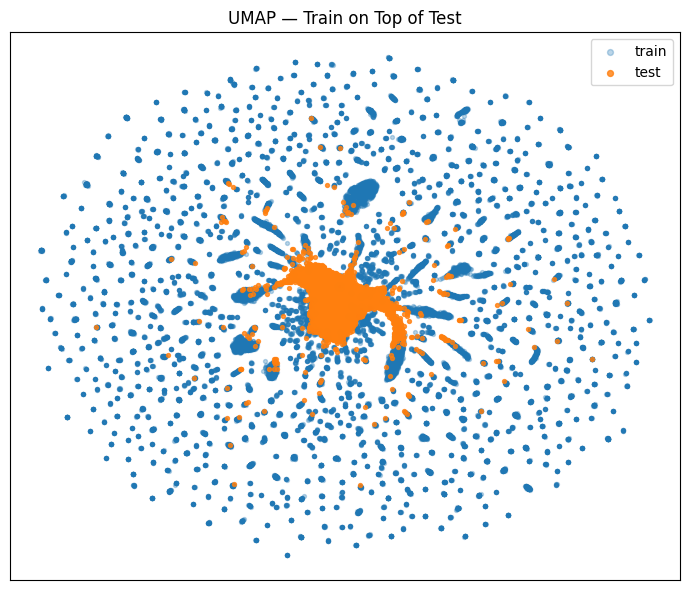

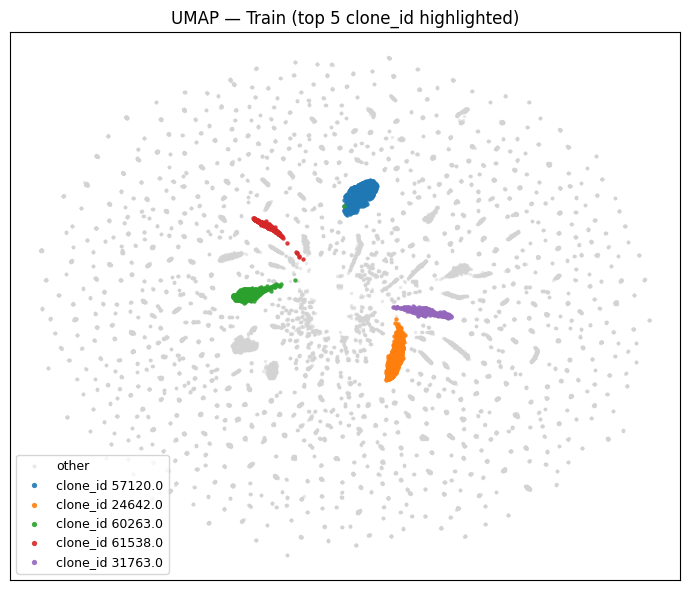

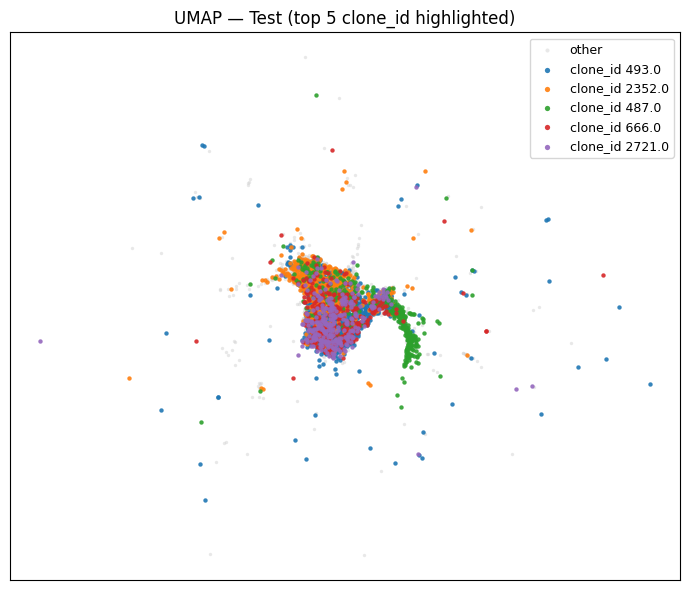

In [8]:
plot_train_test_umap(emb2d_train_001_5, emb2d_test_001_5)
plot_top5_umap(emb2d_train_001_5, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_5,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

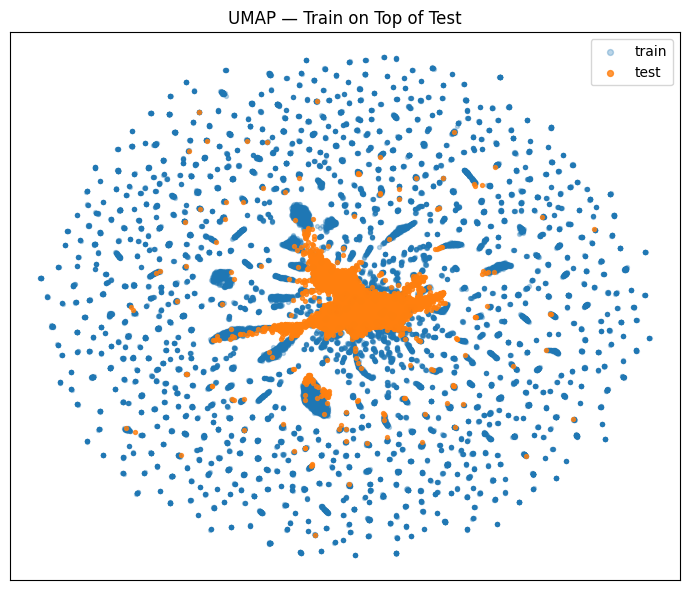

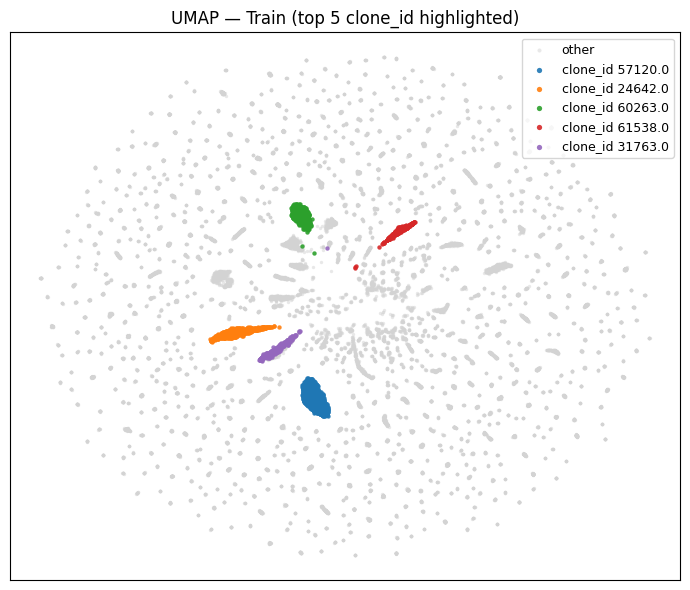

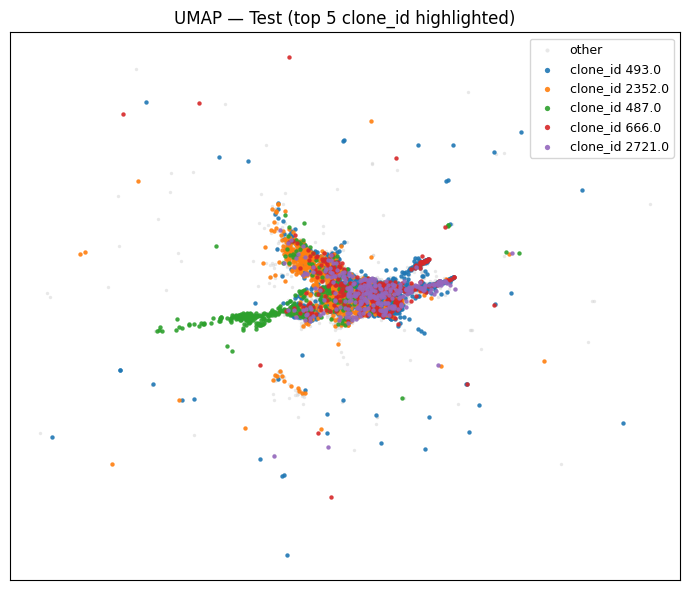

In [9]:
plot_train_test_umap(emb2d_train_001_15, emb2d_test_001_15)
plot_top5_umap(emb2d_train_001_15, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_15,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

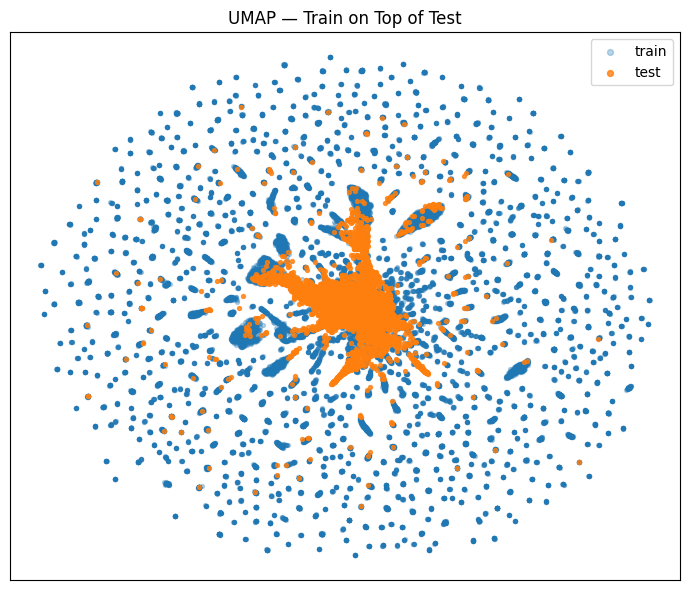

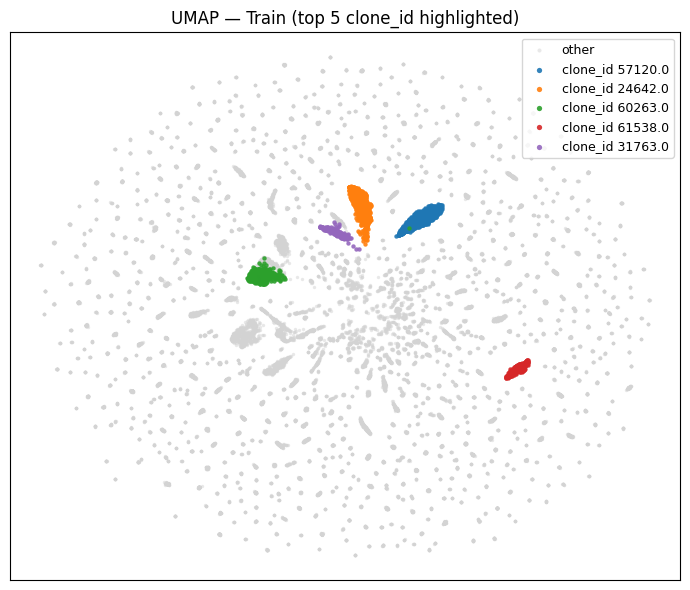

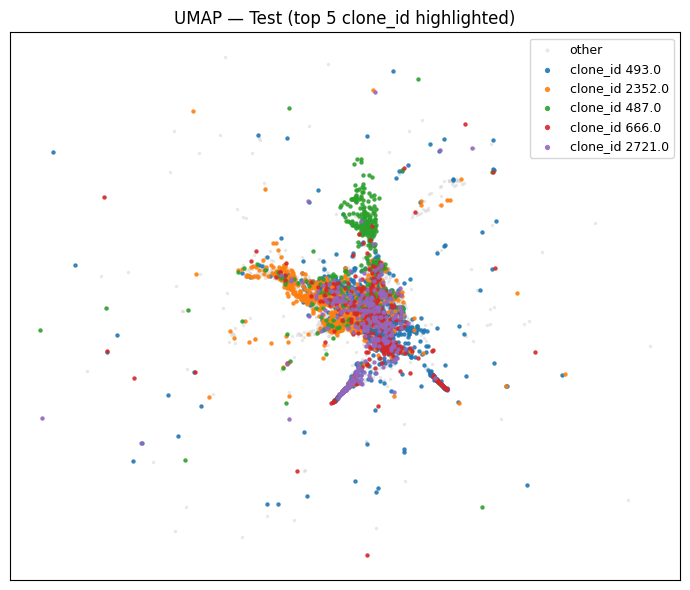

In [10]:
plot_train_test_umap(emb2d_train_001_25, emb2d_test_001_25)
plot_top5_umap(emb2d_train_001_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

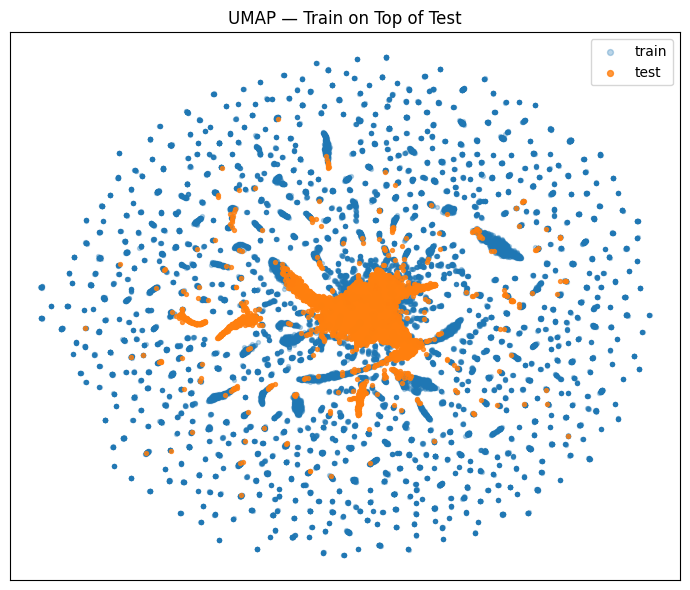

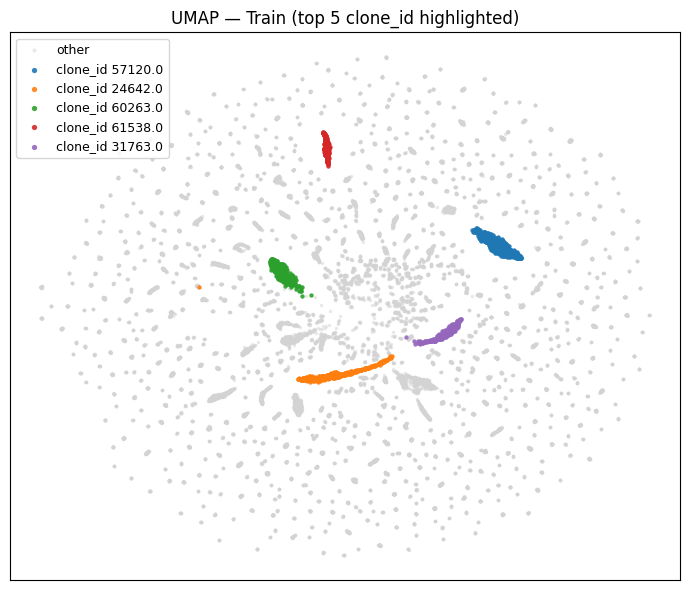

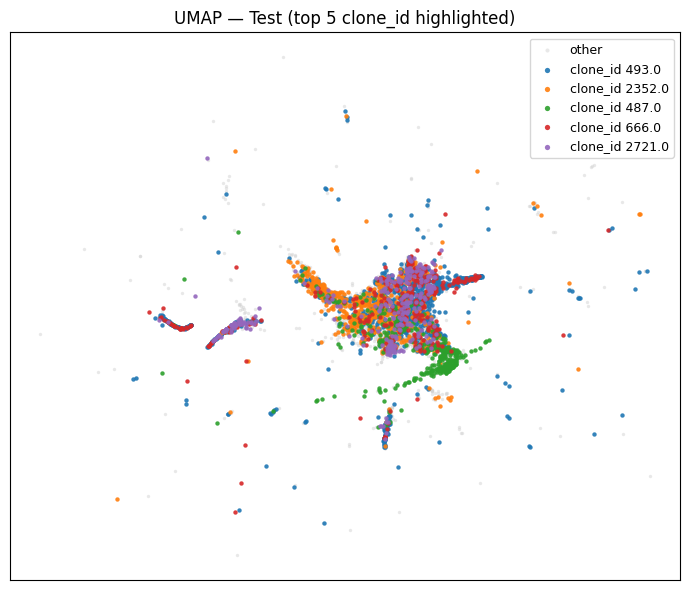

In [11]:
plot_train_test_umap(emb2d_train_001_50, emb2d_test_001_50)
plot_top5_umap(emb2d_train_001_50, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_50,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

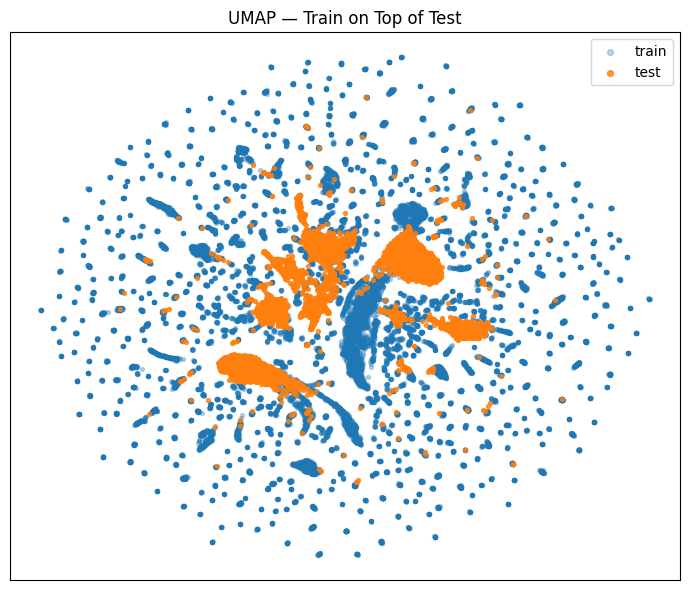

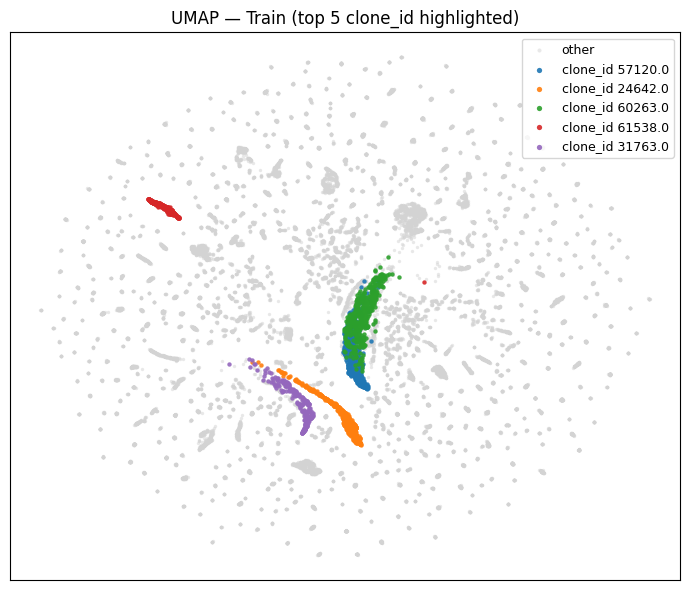

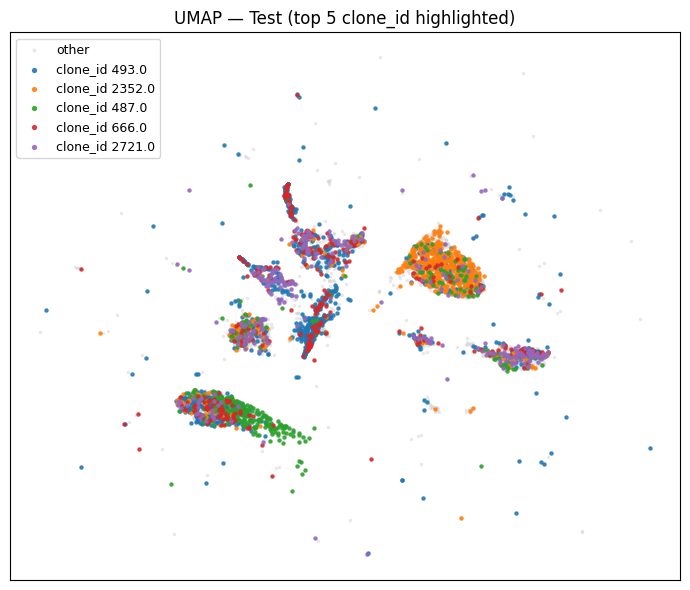

In [12]:
plot_train_test_umap(emb2d_train_005_50, emb2d_test_005_50)
plot_top5_umap(emb2d_train_005_50, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_005_50,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

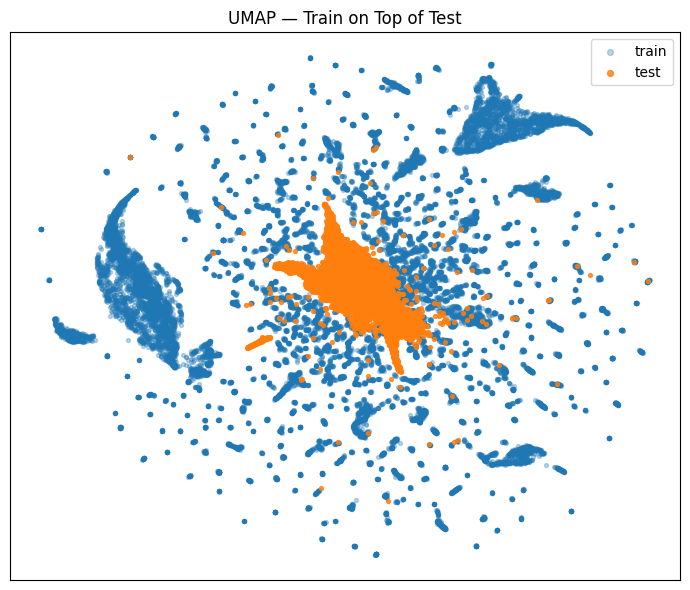

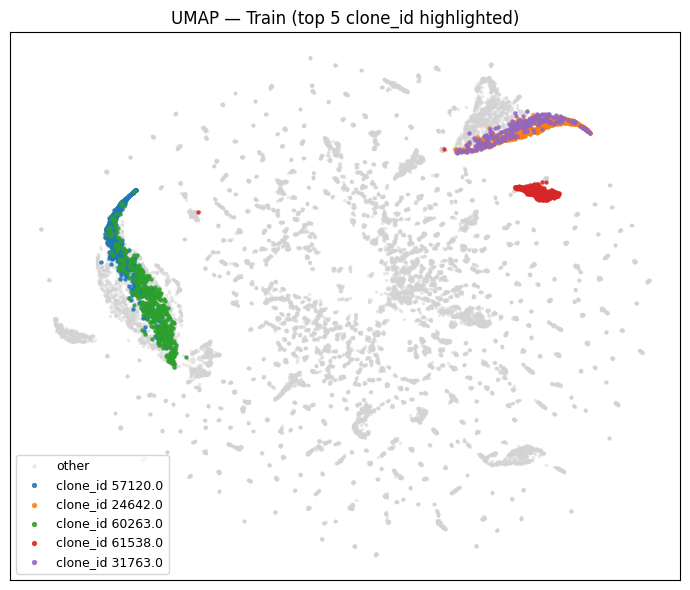

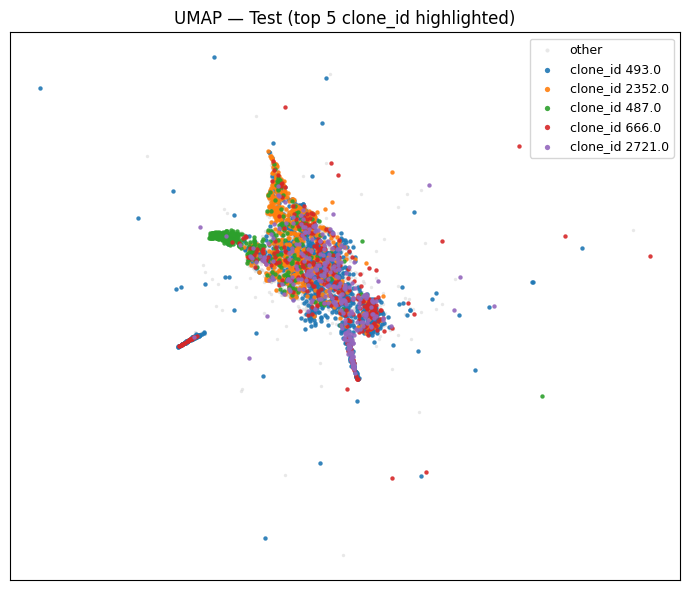

In [10]:
plot_train_test_umap(emb2d_train_01_25, emb2d_test_01_25)
plot_top5_umap(emb2d_train_01_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_01_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

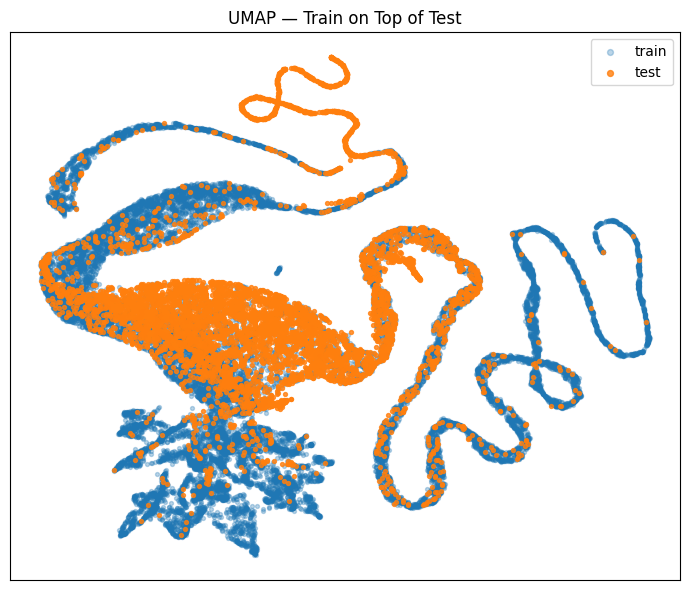

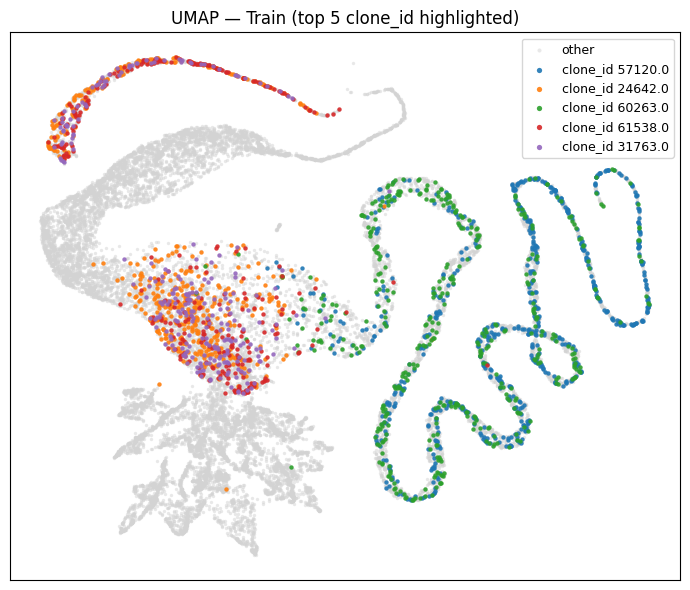

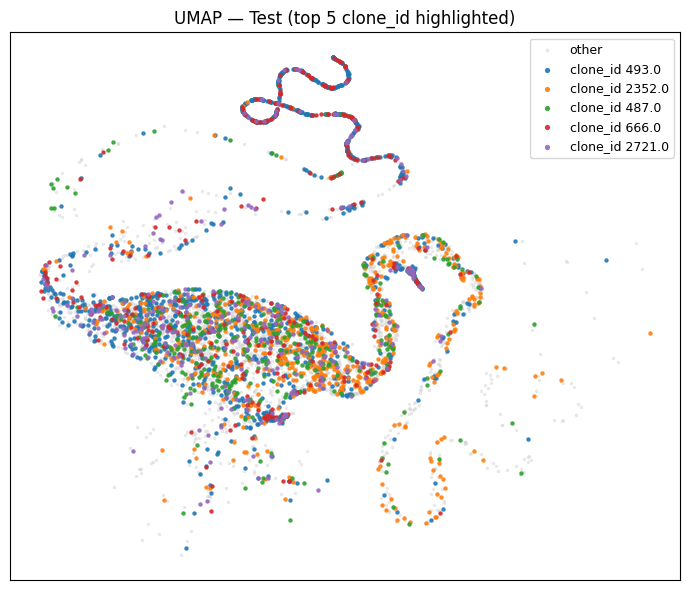

In [11]:
plot_train_test_umap(emb2d_train_1_25, emb2d_test_1_25)
plot_top5_umap(emb2d_train_1_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_1_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

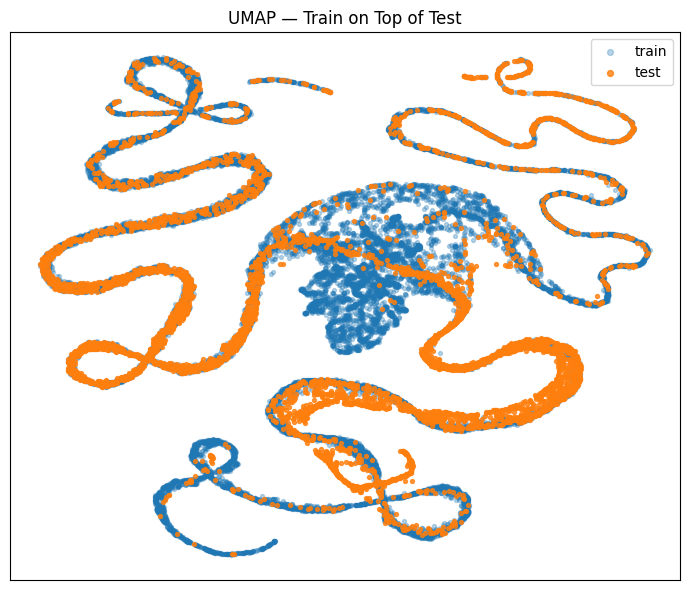

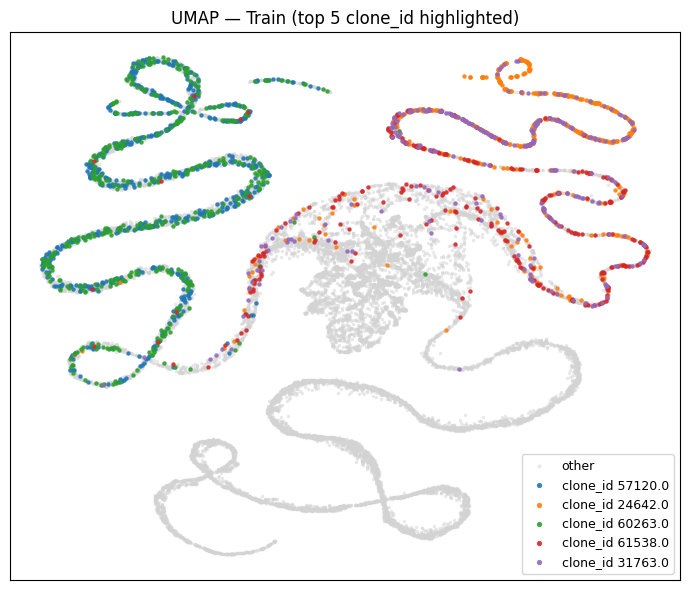

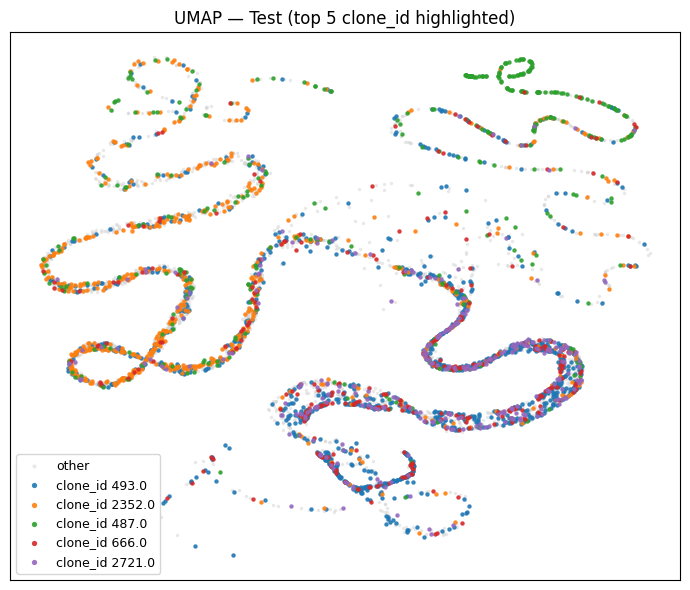

In [12]:
plot_train_test_umap(emb2d_train_2_25, emb2d_test_2_25)
plot_top5_umap(emb2d_train_2_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_2_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

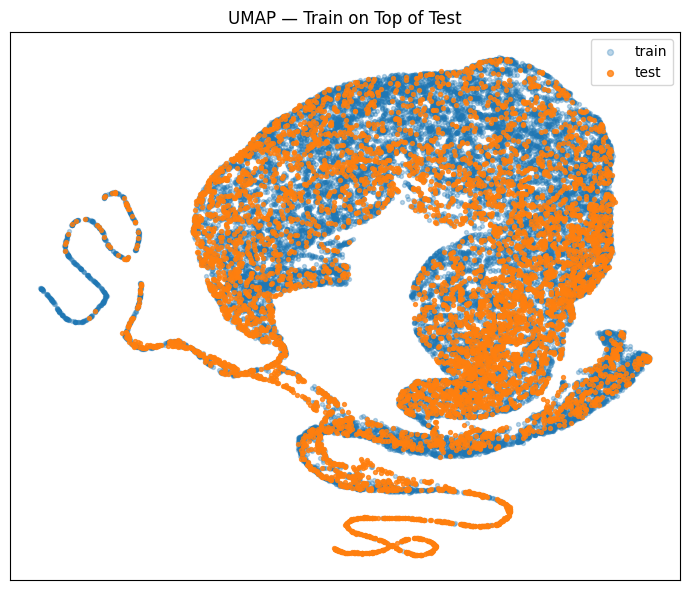

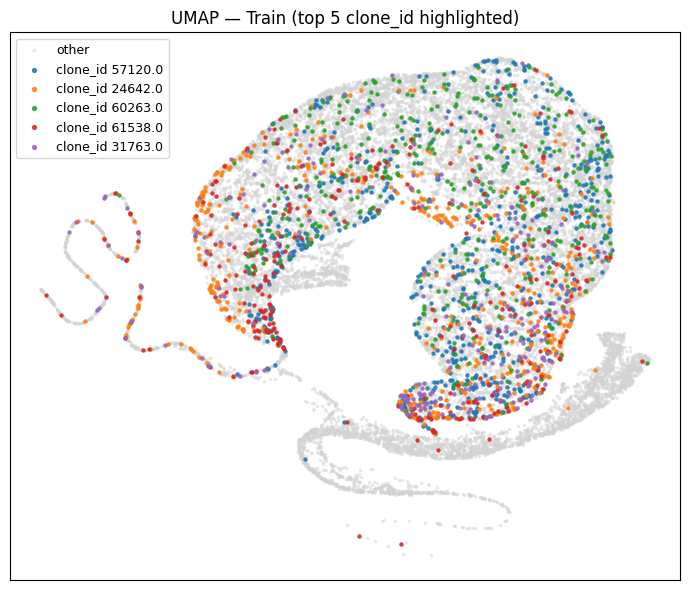

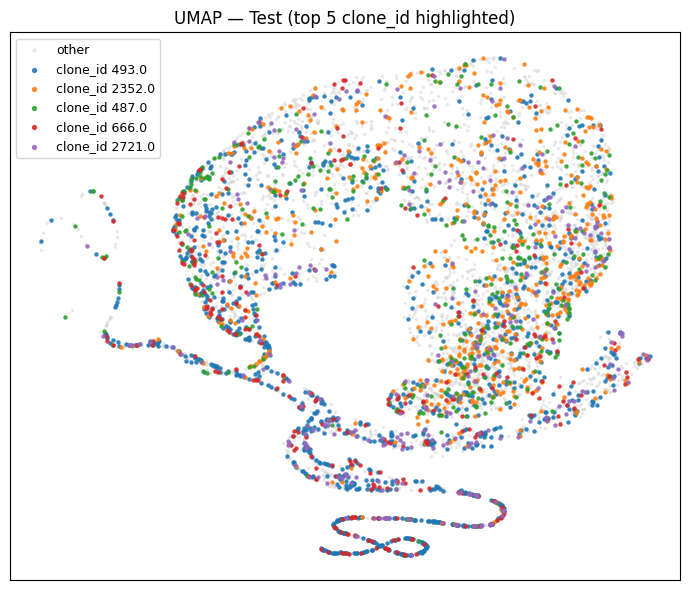

In [13]:
plot_train_test_umap(emb2d_train_10_25, emb2d_test_10_25)
plot_top5_umap(emb2d_train_10_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_10_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")